In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Import Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

In [13]:
df = pd.read_csv('AQI_DaNang_Done.csv')
df.head()

,date,pm25,pm10,o3,no2,so2,co,year,AQI_pm25,AQI_pm10,AQI_o3,AQI_no2,AQI_so2,AQI_co,AQI
0,2019-01-01,26.0,8.0,28.0,12.0,6.0,1.0,2019.0,52.0,8.0,8.7500,6.0,2.4,5.0,52.0
1,2019-01-02,26.0,11.0,69.0,16.0,10.0,4.0,2019.0,52.0,11.0,21.5625,8.0,4.0,20.0,52.0
2,2019-01-03,32.0,15.0,68.0,15.0,1.0,2.0,2019.0,64.0,15.0,21.2500,7.5,0.4,10.0,64.0
3,2019-01-04,40.0,15.0,37.0,9.0,1.0,3.0,2019.0,80.0,15.0,11.5625,4.5,0.4,15.0,80.0
4,2019-01-05,45.0,32.0,48.0,12.0,1.0,2.0,2019.0,90.0,32.0,15.0000,6.0,0.4,10.0,90.0


In [14]:
cols = ['pm25', 'pm10', 'o3', 'no2', 'so2', 'co', 'AQI']

In [15]:
df = df[cols]
df.head()

,pm25,pm10,o3,no2,so2,co,AQI
0,26.0,8.0,28.0,12.0,6.0,1.0,52.0
1,26.0,11.0,69.0,16.0,10.0,4.0,52.0
2,32.0,15.0,68.0,15.0,1.0,2.0,64.0
3,40.0,15.0,37.0,9.0,1.0,3.0,80.0
4,45.0,32.0,48.0,12.0,1.0,2.0,90.0


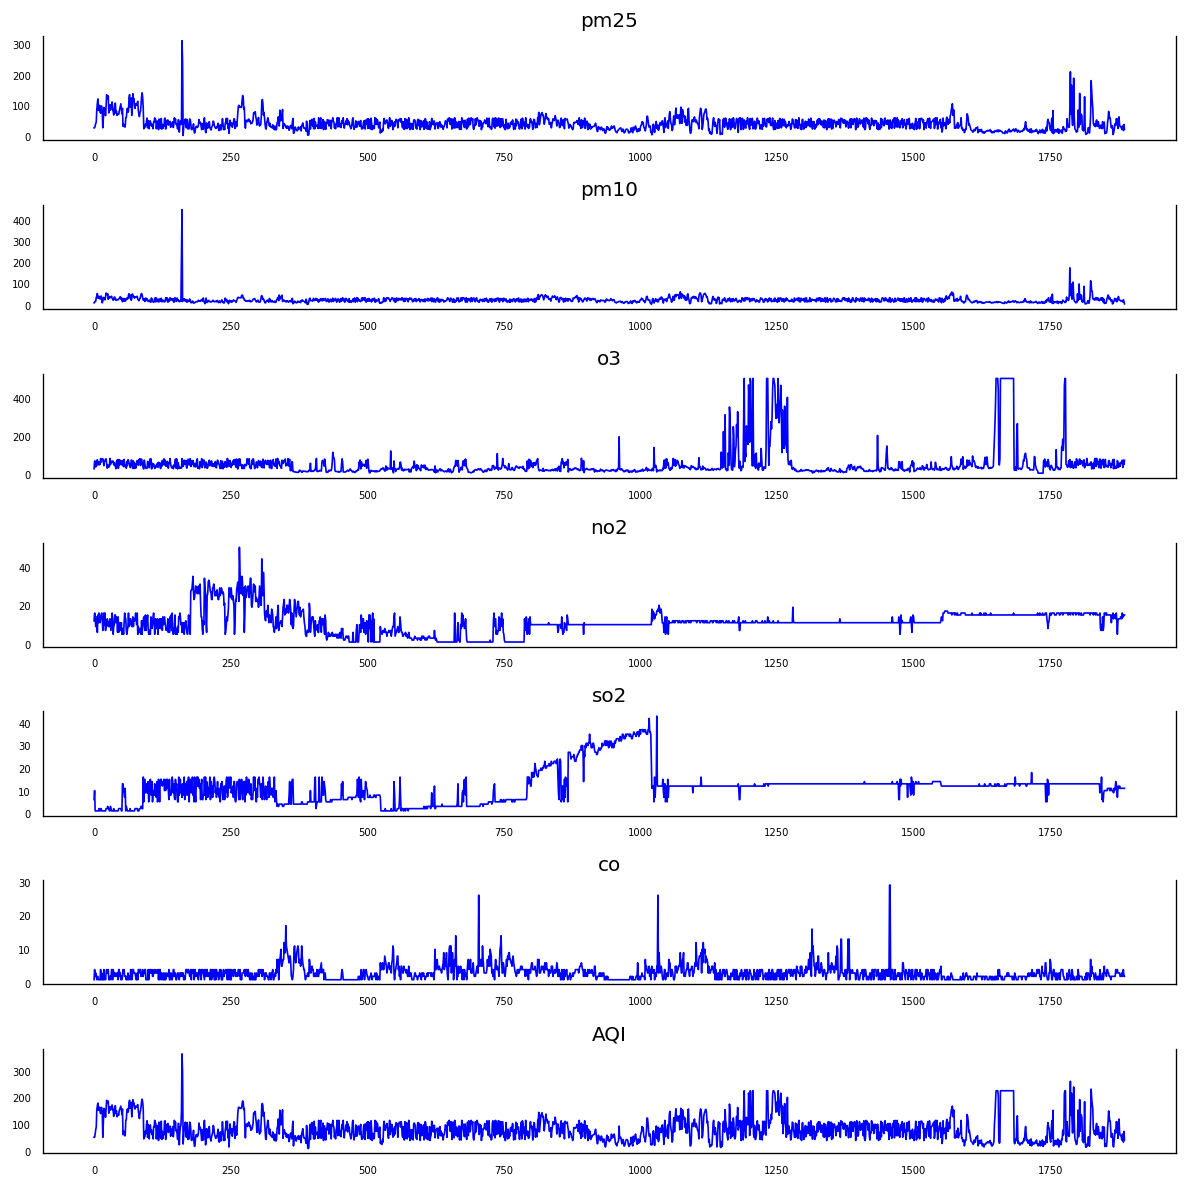

In [16]:
fig, axes = plt.subplots(nrows=7, ncols=1, dpi=120, figsize=(10,10))
for i, ax in enumerate(axes.flatten()):
    data = df[df.columns[i]]
    ax.plot(data, color='blue', linewidth=1)
    # Decorations
    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

### 7. Cointegration Test ###

In [17]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(df)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
pm25   ::  531.35    > 111.7797  =>   True
pm10   ::  323.73    > 83.9383   =>   True
o3     ::  194.53    > 60.0627   =>   True
no2    ::  110.45    > 40.1749   =>   True
so2    ::  58.68     > 24.2761   =>   True
co     ::  19.45     > 12.3212   =>   True
AQI    ::  1.63      > 4.1296    =>   False


In [18]:
# Train, test
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR  

time_series = df[cols]
train_data = time_series[:int(0.8*len(time_series))]
test_data = time_series[int(0.8*len(time_series)):]

### 9. Check for Stationarity and Make the Time Series Stationary ###

In [19]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")  

In [20]:
# ADF Test on each column
for name, column in train_data.items():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "pm25" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -5.2571
 No. Lags Chosen       = 13
 Critical value 1%     = -3.435
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "pm10" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -17.2036
 No. Lags Chosen       = 2
 Critical value 1%     = -3.435
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "o3" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05


In [21]:
import warnings
warnings.filterwarnings("ignore")

In [22]:
df_diff = train_data.diff().dropna()
df_diff

,pm25,pm10,o3,no2,so2,co,AQI
1,0.0,3.0,41.0,4.0,4.0,3.0,0.000000
2,6.0,4.0,-1.0,-1.0,-9.0,-2.0,12.000000
3,8.0,0.0,-31.0,-6.0,0.0,1.0,16.000000
4,5.0,17.0,11.0,3.0,0.0,-1.0,10.000000
5,40.0,11.0,18.0,2.0,0.0,-1.0,63.571429
...,...,...,...,...,...,...,...
1504,15.0,-19.0,0.0,0.0,1.0,0.0,27.666667
1505,-36.0,19.0,3.0,0.0,-1.0,-3.0,-69.666667
1506,3.0,-18.0,6.0,0.0,0.0,3.0,6.000000
1507,1.0,2.0,5.0,0.0,0.0,-1.0,2.000000


In [23]:
# ADF Test on each column
for name, column in df_diff.items():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "pm25" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -17.2937
 No. Lags Chosen       = 12
 Critical value 1%     = -3.435
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "pm10" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -13.8671
 No. Lags Chosen       = 19
 Critical value 1%     = -3.435
 Critical value 5%     = -2.863
 Critical value 10%    = -2.568
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "o3" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.0

### 10. Xây dựng mô hình VAR ###

In [24]:
model = VAR(df_diff)

In [25]:
# Tìm Lag Order
x = model.select_order(maxlags=12)
x.summary()

,AIC,BIC,FPE,HQIC
0,30.81,30.84,2.405e+13,30.82
1,29.31,29.51,5.381e+12,29.39
2,28.93,29.30,3.654e+12,29.07
3,28.67,29.21*,2.817e+12,28.87
4,28.56,29.28,2.530e+12,28.83*
5,28.51,29.41,2.417e+12,28.85
6,28.44,29.51,2.238e+12,28.83
7,28.40,29.64,2.157e+12,28.86
8,28.41,29.83,2.189e+12,28.94
9,28.42,30.01,2.198e+12,29.01


In [26]:
# lag_order = 12
fitted_model = model.fit(12)
fitted_model.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 24, May, 2024
Time:                     09:09:15
--------------------------------------------------------------------
No. of Equations:         7.00000    BIC:                    30.5025
Nobs:                     1496.00    HQIC:                   29.1773
Log likelihood:          -35500.1    FPE:                2.13864e+12
AIC:                      28.3903    Det(Omega_mle):     1.45257e+12
--------------------------------------------------------------------
Results for equation pm25
              coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------
const           -0.100244         0.353354           -0.284           0.777
L1.pm25         -0.869874         0.068134          -12.767           0.000
L1.pm10          0.750752         0.029256           25.661           0.000
L1.o3

In [27]:
lag_order = fitted_model.k_ar
lag_order

12

In [28]:
predictions = fitted_model.forecast(df_diff.values[-lag_order:], steps=len(test_data))
predictions

array([[-5.30214754e+00, -4.32985550e-01,  6.66622066e+00, ...,
         3.14830848e-01, -2.75295725e-01, -1.51626661e+01],
       [-5.62104182e+00, -4.69155458e+00, -4.14541495e+00, ...,
         9.06842139e-02, -1.82667190e-01, -8.97629810e+00],
       [-2.89593805e+00, -7.36418351e-01,  2.20070156e+00, ...,
        -4.77876177e-01,  2.15958232e-02, -4.87940472e+00],
       ...,
       [-3.10714860e-02, -6.83774119e-03, -2.73687438e-02, ...,
         7.82776799e-03,  4.46721642e-04, -5.11063064e-02],
       [-3.10714860e-02, -6.83774119e-03, -2.73687438e-02, ...,
         7.82776799e-03,  4.46721642e-04, -5.11063064e-02],
       [-3.10714860e-02, -6.83774119e-03, -2.73687438e-02, ...,
         7.82776799e-03,  4.46721642e-04, -5.11063064e-02]])

In [30]:
df_forecast = pd.DataFrame(predictions, index=df.index[int(0.8*len(time_series)):], columns=df.columns + '_1d')
df_forecast

,pm25_1d,pm10_1d,o3_1d,no2_1d,so2_1d,co_1d,AQI_1d
1509,-5.302148,-0.432986,6.666221,-0.066040,0.314831,-0.275296,-15.162666
1510,-5.621042,-4.691555,-4.145415,0.348266,0.090684,-0.182667,-8.976298
1511,-2.895938,-0.736418,2.200702,-0.332275,-0.477876,0.021596,-4.879405
1512,1.445656,-2.101230,0.584379,0.797796,0.185402,0.292406,7.192100
1513,-2.681190,3.512070,-17.155352,-0.509614,-0.427142,-0.066844,-11.036323
...,...,...,...,...,...,...,...
1882,-0.031071,-0.006838,-0.027369,-0.001059,0.007828,0.000447,-0.051106
1883,-0.031071,-0.006838,-0.027369,-0.001059,0.007828,0.000447,-0.051106
1884,-0.031071,-0.006838,-0.027369,-0.001059,0.007828,0.000447,-0.051106
1885,-0.031071,-0.006838,-0.027369,-0.001059,0.007828,0.000447,-0.051106


In [55]:
def invert_transformation(df_train, df_forecast):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc
df_results = invert_transformation(train_data, df_forecast)   
fc_cols = ['pm25_forecast', 'pm10_forecast', 'o3_forecast', 'no2_forecast',
       'so2_forecast', 'co_forecast', 'AQI_forecast']
df_results = df_results[fc_cols]
df_results

,pm25_forecast,pm10_forecast,o3_forecast,no2_forecast,so2_forecast,co_forecast,AQI_forecast
1509,40.697852,24.567014,35.666221,10.933960,13.314831,2.724704,76.837334
1510,35.076811,19.875460,31.520806,11.282226,13.405515,2.542037,67.861036
1511,32.180873,19.139042,33.721507,10.949951,12.927639,2.563633,62.981631
1512,33.626529,17.037812,34.305886,11.747747,13.113041,2.856039,70.173731
1513,30.945339,20.549881,17.150534,11.238133,12.685899,2.789196,59.137408
...,...,...,...,...,...,...,...
1882,22.947124,18.148734,17.631559,10.844496,15.917486,2.970236,48.706748
1883,22.916052,18.141897,17.604191,10.843437,15.925313,2.970682,48.655641
1884,22.884981,18.135059,17.576822,10.842377,15.933141,2.971129,48.604535
1885,22.853909,18.128221,17.549453,10.841318,15.940969,2.971576,48.553429


In [82]:
# Dự đoán 30 ngày tiếp theo
predictions_future = fitted_model.forecast(test_data.values[-12:], steps=30)
prediect_data_index = pd.RangeIndex(start=len(df)-1, stop=len(df)+29, step=1)

df_forecast_30days = pd.DataFrame(predictions_future, index=prediect_data_index, columns=df.columns + '_1d')
df_forecast_30days.head()

,pm25_1d,pm10_1d,o3_1d,no2_1d,so2_1d,co_1d,AQI_1d
1886,-74.591981,-46.591679,-125.818964,-31.237166,-19.970523,-10.180936,-159.400962
1887,-50.680168,-7.178273,-37.979996,-13.749262,-0.893750,0.054510,-76.784579
1888,-8.361029,12.682567,-7.126136,-6.251509,-1.205763,-2.130514,-15.442881
1889,15.630512,-8.506286,-2.829475,-1.747368,-0.320257,0.118900,24.184477
1890,-1.263146,-6.808816,2.172837,-0.685994,-1.090264,0.453394,3.498266


In [84]:
def invert_transformation(df_train, df_forecast):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

df_results_30days = invert_transformation(test_data, df_forecast_30days)   
fc_cols = ['pm25_forecast', 'pm10_forecast', 'o3_forecast', 'no2_forecast',
       'so2_forecast', 'co_forecast', 'AQI_forecast']
df_results_30days = df_results_30days[fc_cols]
df_results_30days.head()

,pm25_forecast,pm10_forecast,o3_forecast,no2_forecast,so2_forecast,co_forecast,AQI_forecast
1886,-53.591981,-43.591679,-53.818964,-16.237166,-8.970523,-8.180936,-117.400962
1887,-104.272149,-50.769953,-91.798960,-29.986428,-9.864273,-8.126426,-194.185540
1888,-112.633178,-38.087386,-98.925096,-36.237937,-11.070035,-10.256939,-209.628422
1889,-97.002666,-46.593672,-101.754571,-37.985305,-11.390292,-10.138039,-185.443944
1890,-98.265812,-53.402488,-99.581735,-38.671299,-12.480556,-9.684646,-181.945679


### 11. Biểu diễn đồ thị ###

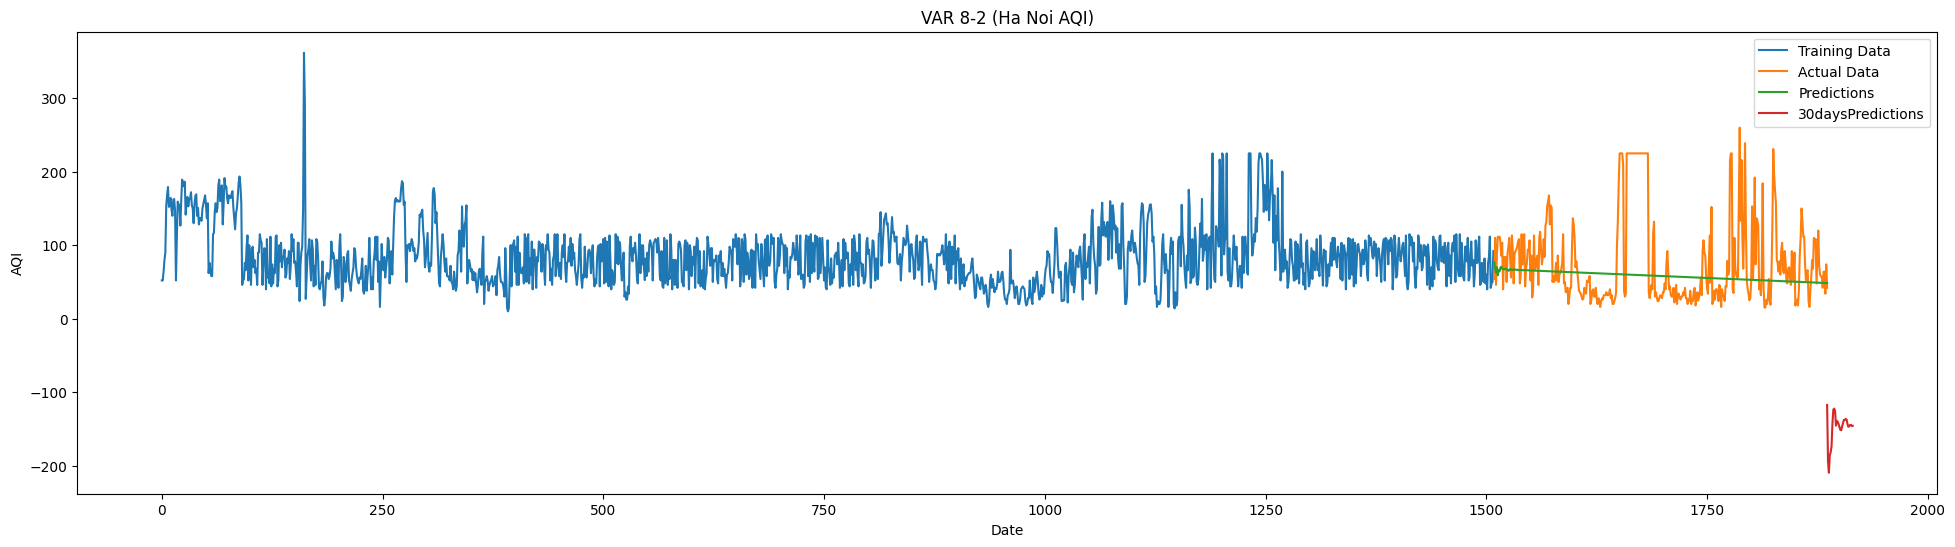

In [86]:
plt.figure(figsize=(24, 6))
plt.plot(train_data.index, train_data.AQI, label='Training Data')
plt.plot(test_data.index, test_data.AQI, label='Actual Data')
plt.plot(test_data.index, df_results.AQI_forecast, label='Predictions')  

plt.plot(prediect_data_index, df_results_30days.AQI_forecast, label='30daysPredictions')

plt.title('VAR 8-2 (Ha Noi AQI)')
plt.xlabel('Date')
plt.ylabel('AQI')
plt.legend()
plt.show()